# **Conception et Entrainement du modèle**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier, plot_importance, to_graphviz
from sklearn.model_selection import  GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump, load

In [12]:
import os
os.chdir(r'C:\Users\LENOVO\Documents\Bank Customer\xgboost\Smote')
print(os.getcwd())

c:\Users\LENOVO\Documents\Bank Customer\xgboost\Smote


In [13]:
# Importation de la donnée
df = pd.read_csv("work_data.csv")
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,732,0,1,41,8,0.0,2,1,1,170886.17,0
1,636,2,0,32,8,0.0,2,1,0,138555.46,0


In [14]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [15]:
y.value_counts()

0    7948
1    2032
Name: Exited, dtype: int64

In [16]:
# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Enregistrement du scaler
dump(scaler, './scaler.joblib')

['./scaler.joblib']

In [86]:
# Partition
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

## le XGboost

*Optimisation du modèle*

In [87]:
# Définition des paramètres à optimiser
param_grid = {
    # max_depth est la profondeur maximale de chaque arbre. Une valeur plus élevée rendra le modèle plus complexe et pourrait entraîner un surapprentissage.
    'max_depth': [3, 4, 5,6],    
    'learning_rate': [0.01, 0.1, 0.2, 0.25],    
    # n_estimators est le nombre d'arbres à construire.
    'n_estimators': [80, 100, 200, 300,500,1000],

}

# Création de l'objet GridSearch

boost = XGBClassifier()
grid_search = GridSearchCV(boost, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.25],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [80, 100, 200, 300, 500, 1000]},
             verbose=2)

In [88]:
# Affichage des meilleurs paramètres
print("Best parameters found: ", grid_search.best_params_)
print ("Meilleure config: ", grid_search.best_estimator_)

Best parameters found:  {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 80}
Meilleure config:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


### On observe un désequilibre important dans la variable cible. Pour cela je vais utiliser le 'scale_pos_weight' qui est l'un des paramètres de xgboost.

**1er cas: Utilisation du poids**

L'objectif est de noté au modèle la classe minoritaire. Pour cela, le poids de classe calculé représente le rapport entre le nombre d'instances de la classe majoritaire (0) et le nombre d'instances de la classe minoritaire (1). Une valeur de poids supérieure à 1 signifie que vous accordez plus de poids à la classe minoritaire, ce qui est généralement souhaitable lorsque la classe minoritaire est sous-représentée.

In [89]:
# parametrons suivant les meilleurs paramètres trouvés
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['eta'] = 0.3
param['gamma'] = 0
param['learning_rate'] = 0.2
param['n_estimators'] = 100
param['max_depth'] = 3
param['min_child_weight'] = 1
param['max_delta_step'] = 0
param['subsample'] = 1
param['colsample_bytree'] = 1
param['seed'] = 0
param['base_score'] = 0.5

# Calcul du poids de classe
weight = len(df[df['Exited'] == 0]) / len(df[df['Exited'] == 1])
print("Le poids est = ",weight)

param['scale_pos_weight'] = weight

clf = XGBClassifier(**param)


Le poids est =  3.0


In [90]:
boost = clf.fit(X_train, y_train)


['modele_xgb.joblib']

In [91]:
# Utilisation du meilleur modèle trouvé pour la prédiction
#best_model = grid_search.best_estimator_

y_train_pred = boost.predict(X_train)
y_test_pred = boost.predict(X_test)

In [104]:
print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      6353
           1       0.61      0.75      0.67      1631

    accuracy                           0.85      7984
   macro avg       0.77      0.81      0.79      7984
weighted avg       0.87      0.85      0.86      7984


Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1595
           1       0.57      0.70      0.63       401

    accuracy                           0.83      1996
   macro avg       0.75      0.79      0.76      1996
weighted avg       0.85      0.83      0.84      1996



In [96]:
dump(boost, 'modele_xgb_85.joblib')

['modele_xgb_85.joblib']

In [97]:
confusion_mat = confusion_matrix(y_test, y_test_pred)
print(confusion_mat)

[[1384  211]
 [ 119  282]]


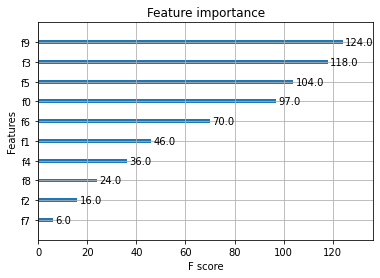

Du plus au moins important: 
Age > Estimated Salary > Balance > CreditScore > NumOfProducts > Geography > Tenure > IsActiveMember > Gender > HasCrCard


In [95]:
plot_importance(boost)
plt.show()
print("Du plus au moins important: ")
print("Age > Estimated Salary > Balance > CreditScore > NumOfProducts > Geography > Tenure > IsActiveMember > Gender > HasCrCard")

**2eme cas: La technique de suréchantillonnage**

Elle permet d'équilibrer le nombre d'instances entre les classes. L'une des méthodes couramment utilisées pour le suréchantillonnage de la classe minoritaire est l'algorithme SMOTE (Synthetic Minority Over-sampling Technique).
Cela permet d'augmenter le nombre d'instances de la classe minoritaire sans simplement répliquer les échantillons existants. Cela peut aider à prévenir le surapprentissage et à améliorer les performances du modèle.

https://kobia.fr/imbalanced-data-smote/ 

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=1, sampling_strategy=0.3, random_state=42)
X_train_sur, y_train_sur = smote.fit_resample(X_scaled, y)

In [33]:
X_scaled.shape, X_train_sur.shape

((9980, 10), (10332, 10))

In [34]:
print(y_train.value_counts())
print(y_train_sur.value_counts())

0    6353
1    1631
Name: Exited, dtype: int64
0    7948
1    2384
Name: Exited, dtype: int64


In [35]:
param_grid = {
    # max_depth est la profondeur maximale de chaque arbre. Une valeur plus élevée rendra le modèle plus complexe et pourrait entraîner un surapprentissage.
    'max_depth': [3, 4, 5,6],    
    'learning_rate': [0.01, 0.1, 0.2, 0.25],    
    # n_estimators est le nombre d'arbres à construire.
    'n_estimators': [80, 100, 200, 300,500,1000],

}

# Création de l'objet GridSearch

boost = XGBClassifier()
grid_search = GridSearchCV(boost, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sur, y_train_sur)

print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}


In [38]:
# Utilisation du meilleur modèle trouvé pour la prédiction
xboost = grid_search.best_estimator_
xboost = xboost.fit(X_train_sur, y_train_sur)

y_train_predi = xboost.predict(X_train_sur)
y_test_predi = xboost.predict(X_test)

In [39]:
# Classification Report
print("\nTrain Classification Report:")
print(classification_report(y_train_sur, y_train_predi))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predi))


Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7948
           1       0.85      0.59      0.70      2384

    accuracy                           0.88     10332
   macro avg       0.87      0.78      0.81     10332
weighted avg       0.88      0.88      0.87     10332


Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1595
           1       0.86      0.60      0.71       401

    accuracy                           0.90      1996
   macro avg       0.88      0.79      0.82      1996
weighted avg       0.90      0.90      0.89      1996



In [41]:
confusion_mat = confusion_matrix(y_test, y_test_predi)
print(confusion_mat)

[[1556   39]
 [ 161  240]]


In [57]:
dump(xboost, 'xgb_smote_88.joblib')

['xgb_smote_88.joblib']

#### Interpretation des resultats

* Pour la classe 0, la précision est de 0.89 et le rappel est de 0.97. Cela signifie que le modèle a correctement identifié 89% des échantillons de la classe 0 et que 97% des échantillons de la classe 0 ont été correctement identifiés par le modèle.
Pour la classe 1, la précision est de 0.85 et le rappel est de 0.59. Cela signifie que le modèle a correctement identifié 85% des échantillons de la classe 1 et que seulement 59% des échantillons de la classe 1 ont été correctement identifiés par le modèle.
* Le score F1 pour la classe 0 est de 0.93 et pour la classe 1 est de 0.70.
* L’exactitude globale du modèle est de 0.88.

Ces résultats indiquent que le modèle est plus performant pour la classe 0 que pour la classe 1 en termes de précision et de rappel. Cependant, il est important de noter que le score F1 pour la classe 1 est relativement faible, ce qui peut indiquer un déséquilibre dans les données d’entraînement ou une difficulté à distinguer les échantillons de la classe 1 des autres classes.

## Test sur une nouvelle donnée

In [77]:
def tester(model, data, scaler):
    df = pd.read_csv(data)
    X = df.drop('Exited', axis=1)
    y = df['Exited']
    
    sc = load(scaler)
    X = sc.fit_transform(X)

    mod = load(model)
    y_pred = mod.predict(X)

    dt = pd.DataFrame({"Real": y, "Predict": y_pred})
    print("Le nombre total de bonne prediction est de ",len(dt[dt['Real'] == dt['Predict']]), " sur", len(df))
    
    # Fonction pour mettre en forme les cases avec des valeurs identiques
    def highlight_identical(row):
        styles = ['background-color: gray' if row['Real'] == row['Predict'] else '' for _ in row]

        return styles

    # Appliquer la mise en forme sur le DataFrame
    styled_df = dt.style.apply(highlight_identical, axis=1)

    # Afficher le DataFrame avec la mise en forme
    return styled_df

In [80]:
test = tester(model='xgb_smote_88.joblib', data='new_data.csv', scaler='scaler.joblib')
test

Le nombre total de bonne prediction est de  12  sur 20


,Real,Predict
0,1,1
1,0,1
2,1,1
3,0,1
4,0,1
5,1,1
6,0,1
7,1,1
8,0,1
9,0,0


In [98]:
tester(model='modele_xgb_85.joblib' ,data='new_data.csv',scaler='scaler.joblib')

Le nombre total de bonne prediction est de  19  sur 20


,Real,Predict
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
5,1,1
6,0,0
7,1,1
8,0,0
9,0,0


# Evaluation du modèle

In [164]:
from sklearn.metrics import roc_curve, roc_auc_score

In [161]:
# Pour le modèle 1 (sans SMOTE)
model1 = load('modele_xgb_85.joblib')
y_prob_model1 = model1.predict_proba(X_test)[:, 1]

# Pour le modèle 2 (avec SMOTE)
model2 = load('xgb_smote_88.joblib')
y_prob_model2 = model2.predict_proba(X_test)[:, 1]


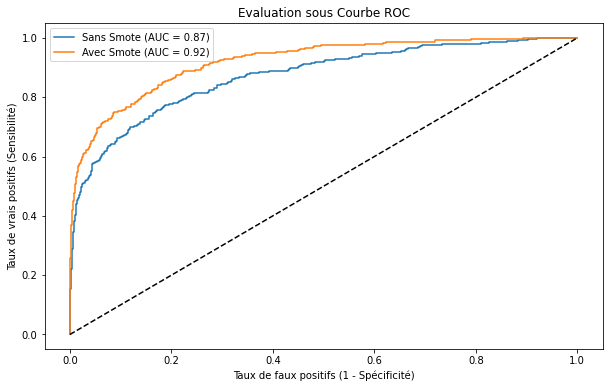

In [166]:
# Pour le modèle 1
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test, y_prob_model1)
roc_auc_model1 = roc_auc_score(y_test, y_prob_model1)

# Pour le modèle 2
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test, y_prob_model2)
roc_auc_model2 = roc_auc_score(y_test, y_prob_model2)

# Tracer les courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_model1, tpr_model1, label=f"Sans Smote (AUC = {roc_auc_model1:.2f})")
plt.plot(fpr_model2, tpr_model2, label=f"Avec Smote (AUC = {roc_auc_model2:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Evaluation sous Courbe ROC')
plt.legend()
plt.show()


## **Interpretation des resultats de la courbe ROC**

Un AUC de 0.87 indique que le modèle sans SMOTE a une bonne capacité de discrimination entre les classes positives et négatives. Plus précisément, il a une probabilité de 87 % de classer correctement un exemple positif au hasard parmi un exemple positif et négatif. C'est généralement considéré comme un résultat solide et indique que le modèle est capable de bien distinguer entre les classes, mais il y a encore un certain degré d'erreur de classification.

Un AUC de 0.92 pour le modèle avec SMOTE indique une meilleure capacité de discrimination par rapport au modèle sans SMOTE. Cela signifie que le modèle avec SMOTE a une probabilité de 92 % de classer correctement un exemple positif au hasard parmi un exemple positif et négatif. Un AUC de 0.92 est considéré comme un résultat très bon, et cela suggère que le modèle avec SMOTE est plus performant pour distinguer entre les classes positives et négatives.

En comparant les deux résultats, nous pouvons conclure que le modèle avec SMOTE a de meilleures performances que le modèle sans SMOTE.

# Conclusion

On en conclut que le modèle utilisant le poids calculé est bien meilleur en terme de performance que le modèle utilisant le smote pour réequilibrage de la donnée. 
    Vérifions l'interprétabilité de chaque variable en utilisant la librairie shap.

.

.

<hr>
<h1> INTERPRETATION DU MODELE </h1>
<hr>

In [99]:
from shapash.explainer.smart_explainer import SmartExplainer

In [103]:
modele = load("modele_xgb_85.joblib")
xpl = SmartExplainer(model=modele)


In [127]:
vos_col = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X_test_df = pd.DataFrame(X_test, columns=vos_col)

In [167]:
X_test_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-1.828498,-0.901838,0.912066,-0.564887,-0.004608,-1.226433,0.809538,0.645919,-1.030733,1.422491
1,-1.269444,1.515659,-1.096412,-0.660225,-1.733372,-0.134248,-0.911269,0.645919,0.970184,1.220190
2,-0.834624,-0.901838,-1.096412,-1.994967,-0.350360,0.100240,-0.911269,0.645919,-1.030733,-0.492217
3,-0.472275,0.306911,0.912066,-1.041580,1.724156,0.595910,-0.911269,0.645919,-1.030733,-1.164989
4,-0.410158,1.515659,0.912066,-0.469548,-0.350360,-1.226433,0.809538,0.645919,-1.030733,1.231340


In [168]:
y_pr= pd.DataFrame(y_test_pred, index=X_test_df.index,columns=["_predict_"])


In [158]:
xpl.compile(
    x= X_test_df, 
    y_pred=y_pr,
    )

In [159]:
xpl.to_pandas(max_contrib=3).head(10)

,_predict_,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
0,0,NumOfProducts,0.809538,1.358549,Age,-0.564887,1.215985,EstimatedSalary,1.422491,-0.405267
1,0,Age,-0.660225,0.939751,IsActiveMember,0.970184,0.439836,Gender,-1.096412,-0.342495
2,0,Age,-1.994967,1.054769,NumOfProducts,-0.911269,-0.339866,Geography,-0.901838,0.321468
3,0,Age,-1.04158,1.16881,Geography,0.306911,-0.634367,NumOfProducts,-0.911269,-0.379191
4,0,NumOfProducts,0.809538,1.336488,Age,-0.469548,1.101081,Gender,0.912066,0.353637
5,0,NumOfProducts,0.809538,1.454173,Age,0.007146,0.536335,IsActiveMember,-1.030733,-0.332233
6,0,Age,0.3885,-0.652836,IsActiveMember,0.970184,0.454881,Geography,-0.901838,0.300222
7,0,Age,-0.27887,0.532505,Geography,-0.901838,0.401103,IsActiveMember,0.970184,0.387303
8,0,IsActiveMember,-1.030733,-0.401886,NumOfProducts,-0.911269,-0.33864,Geography,-0.901838,0.293198
9,0,Age,-0.660225,1.102059,NumOfProducts,0.809538,0.892515,Geography,0.306911,-0.489662


In [ ]:
app = xpl.run_app(title_story="Bank customers data")

INFO:root:Your Shapash application run on http://Daniel-Fianko:8050/


Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8050/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app 'shapash.webapp.smart_app'
 * Debug mode: off


INFO:werkzeug: * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://192.168.79.214:8050 (Press CTRL+C to quit)
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:36] "GET /assets/material-icons.css?m=1689614165.1628783 HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:36] "GET /assets/style.css?m=1689614165.1738725 HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:37] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_6_1m1659961614.12.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:37] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_6_1m1659961614.8.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:37] "GET /_dash-component-suites/dash/deps/react@16.v2_6_1m1659961614.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.79.214 - - [17/Jul/2023 20:24:37] "GET /_dash-comp